In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

#定义使其正常显示中文黑体
plt.rcParams['font.sans-serif'] = ['SimHei']

#用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def dataConversion(v):
    '''
    转换格式为dataFrame
    '''
    new_v = pd.Series(v)
    data = pd.DataFrame({"销量": new_v},)
    return data

In [3]:
def sequencePlot(data):
    '''
    画出时序图
    '''
    data.plot()
    plt.title("销量时序图")
    plt.show()

In [4]:
def selfRelatedPlot(data):
    '''
    画出自相关性图
    '''
    plot_acf(data)
    plt.title("序列自相关情况")
    plt.show()

In [5]:
def partialRelatedPlot(data):
    '''
    画出偏相关图
    '''
    plot_pacf(data)
    plt.title("序列偏相关情况")
    plt.show()

In [6]:
def stableCheck(data):
    '''
    平稳性检测
    '''
    result = adfuller(data['销量'])
    print("原始序列的检验结果为：", result)
    return result

In [7]:
def diffData(data):
    '''
    对数据进行差分
    '''
    D_data = data.diff().dropna()
    return D_data

In [8]:
def whiteNoiseCheck(data):
    '''
    对n阶差分后的序列做白噪声检验
    '''
    result = acorr_ljungbox(data, lags=1)
    #返回统计量和p值
    print("差分序列的白噪声检验结果：", result)
    return result

In [26]:
def selectAragsForModel(D_data):
    '''
    对模型进行定阶
    '''
    #一般阶数不超过length/10
    pmax = int(len(D_data) / 10)
    qmax = int(len(D_data) / 10)
    bic_matrix = []
    for p in range(pmax + 1):
        temp = []
        for q in range(qmax + 1):
            try:
                value = ARIMA(D_data, (p, 1, q)).fit().bic
                temp.append(value)
            except:
                temp.append(None)
            bic_matrix.append(temp)
            
    #将其转换为DataFrame数据结构
    bic_matrix = pd.DataFrame(bic_matrix)
    
    #先使用stack展平，然后使用idxmin找出最小值的位置，
    p,q = bic_matrix.stack().astype('float64').idxmin()
    
    #BIC 最小的p值和q值：0， 1
    print("BIC 最小的p值和q值：%s,%s"%(p, q))
    return p, q

In [27]:
def buildModel(data, p, q):
    '''
    建立ARIMA模型，修复平稳性不通过的情况
    '''
    try:
        model = ARIMA(data, (p, 1, q)).fit()
    except:
        #平稳性不通过
        model = ARIMA(data, (4, 1, 1)).fit()
    try:
        model.summary2()
    except:
        model = ARIMA(data, (4, 1, 1)).fit()
        model.summary2()
    #保存模型
    model.save('model.pkl')
    return model

In [28]:
def predict(model, n=6):
    '''
    进行预测
    '''
    if isinstance(model, str):
        #模型加载
        loaded = ARIMAResults.load('model.pkl')
        
        #预测未来3个单位，即为一个月
        predictions = loaded.forecast(n)
        
        #预测结果为
        pre_result = predictions[0]
        print("预测结果为：", pre_result)
        
        #标准误差为：
        error = predictions[1]
        print("标准误差为：", error)
        
        #置信区间为
        confidence = predictions[2]
        print("置信区间为：", confidence)
    else:
        #预测未来3个单位，即为一个月
        predictions = model.forecast(n)
        
        #预测结果为
        pre_result = predictions[0]
        print("预测结果为：", pre_result)
        
        #标准误差为：
        error = predictions[1]
        print("标准误差为：", error)
        
        #置信区间为
        confidence = predictions[2]
        print("置信区间为：", confidence)
    return pre_result

In [29]:
fname = './data/sales.xls'

In [30]:
def loadData(fname):
    #导入数据
    data = pd.read_excel(fname, index_col='日期', header=0)
    return data

In [31]:
def roundResult(result):
    '''
    默认预测6个点，即为两个月的数据，否则不会合并
    '''
    if len(result) == 6:
        salesArr = [round(sum(result[0:3])), round(sum(result[3:6]))]
    else:
        salesArr = [round(r) for r in result]
    
    #对预测结果进行业务判断，小于等于0就预测为1
    sales = []
    for s in salesArr:
        if s <= 0:
            s = 1
        sales.append(s)
    return sales

In [36]:
def predictSales(fname, n=6, isVisiable=False):
    '''
    程序执行的入口
    '''
    
    #加载数据
    data = loadData(fname)
    
    #对数据进行差分处理
    D_data = diffData(data)
    
    if isVisiable:
        #画出差分后的时序图
        sequencePlot(D_data)
        #画出自相关图
        selfRelatedPlot(D_data)
        #画出偏相关图
        partialRelatedPlot(D_data)
    
    #对差分序列平稳性检测
    D_result = stableCheck(D_data)
    print("差分序列的ADF 检验结果为：", D_result)
    
    #对模型进行定阶
    p, q = selectAragsForModel(D_data)
    
    #建立模型
    model = buildModel(data, p, q)
    
    #对销量进行预测
    result = predict(model, n).tolist()
    
    #对结果进行取整处理
    result = roundResult(result)
    print("预测未来%d个点的销量为："%n, result)
    return result

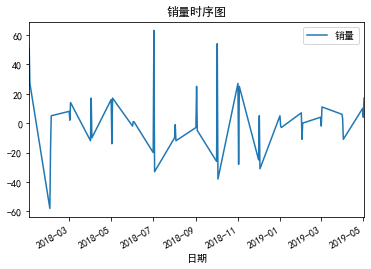

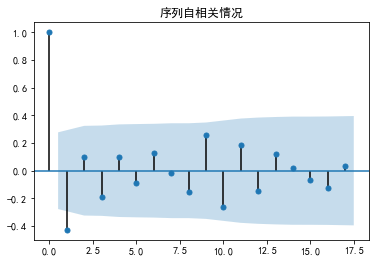

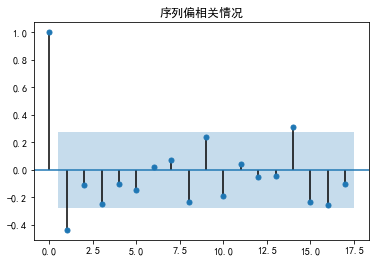

原始序列的检验结果为： (-11.591264215071003, 2.7882688431803552e-21, 0, 49, {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}, 322.56426240750625)
差分序列的ADF 检验结果为： (-11.591264215071003, 2.7882688431803552e-21, 0, 49, {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}, 322.56426240750625)


C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency infor

C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. f

C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. f

BIC 最小的p值和q值：6,1
预测结果为： [35.99773345 36.4056154  34.4583983  37.38532923 35.54763637 36.16415872]
标准误差为： [17.93349613 18.6666322  19.20966761 19.34871492 19.91054226 20.11771147]
置信区间为： [[ 0.84872691 71.14673999]
 [-0.18031143 72.99154223]
 [-3.19185837 72.10865496]
 [-0.53745517 75.30811363]
 [-3.47630938 74.57158211]
 [-3.26583122 75.59414866]]
预测未来6个点的销量为： [107, 109]


In [37]:
result = predictSales(fname, 6, isVisiable=True)